# Explore here

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
import pickle
import os
import kaggle
import numpy as np


## Carga y Preparación de Datos

In [26]:
# Cargar el dataset
file_path = '/Users/joanafernandes/Data Science Bootcamp/24) JF-sistema_deteccion_agua_project/data/raw/acea-water-prediction/acea-water-prediction/Lake_Bilancino.csv'
data = pd.read_csv(file_path)
data.head()

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,03/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
1,04/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2,05/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
3,06/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
4,07/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.44,0.31


In [27]:
# Seleccionar la columna relevante
data_select = data[['Date', 'Lake_Level']].copy() # Usar .copy() para evitar SettingWithCopyWarning

# Convertir la columna 'Date' al formato datetime y establecerla como índice
data_select['Date'] = pd.to_datetime(data_select['Date'], dayfirst=True)
data_select.set_index('Date', inplace=True)

# Extraer la serie temporal
Lake_Level = data_select['Lake_Level']

# Imprimir información básica
print("Primeras filas de la serie temporal:")
print(Lake_Level.head())
print("\nInformación de la serie temporal:")
print(Lake_Level.info())
print("\nValores nulos:", Lake_Level.isnull().sum())
print("Valores duplicados:", Lake_Level.duplicated().sum())

Primeras filas de la serie temporal:
Date
2002-06-03    249.43
2002-06-04    249.43
2002-06-05    249.43
2002-06-06    249.43
2002-06-07    249.44
Name: Lake_Level, dtype: float64

Información de la serie temporal:
<class 'pandas.core.series.Series'>
DatetimeIndex: 6603 entries, 2002-06-03 to 2020-06-30
Series name: Lake_Level
Non-Null Count  Dtype  
--------------  -----  
6603 non-null   float64
dtypes: float64(1)
memory usage: 103.2 KB
None

Valores nulos: 0
Valores duplicados: 5780


## Análisis de la Serie Temporal


--- Análisis de la Serie Temporal ---


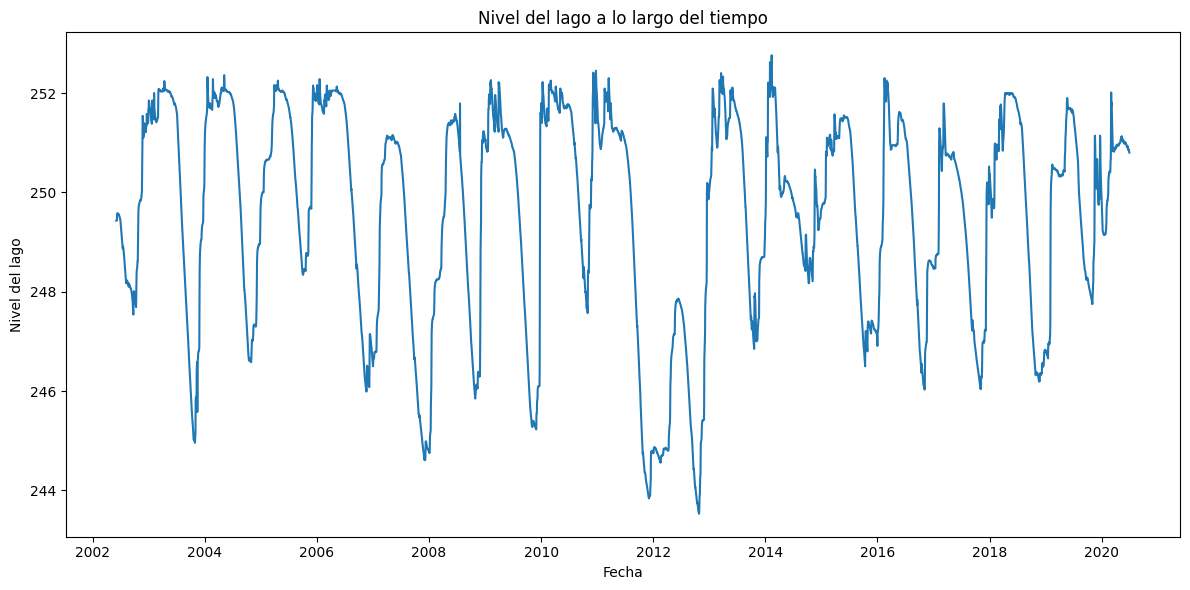


Descomposición de la serie temporal (periodo=365):


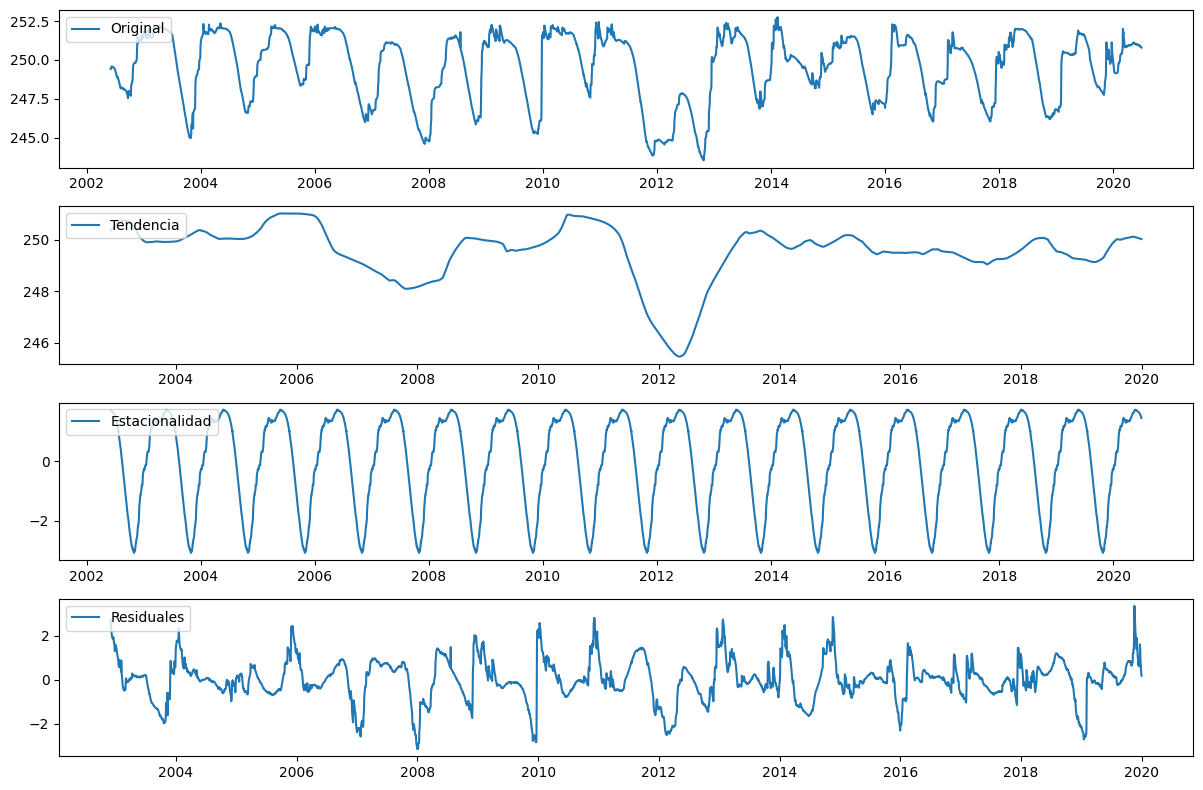


Prueba de Dickey-Fuller:
Test Statistic                -6.880991e+00
p-value                        1.433634e-09
#Lags Used                     3.500000e+01
Number of Observations Used    6.567000e+03
Critical Value (1%)           -3.431346e+00
Critical Value (5%)           -2.861980e+00
Critical Value (10%)          -2.567004e+00
dtype: float64

Interpretación de la prueba de Dickey-Fuller:
Un p-value mayor que 0.05 sugiere que la serie temporal no es estacionaria.

Gráfico de autocorrelación (ACF):


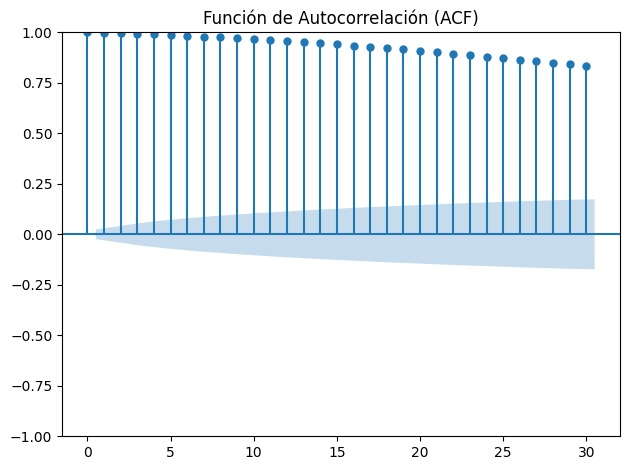

In [28]:
print("\n--- Análisis de la Serie Temporal ---")

# Visualización de la serie temporal
plt.figure(figsize=(12, 6))
sns.lineplot(data=Lake_Level)
plt.title('Nivel del lago a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Nivel del lago')
plt.tight_layout()
plt.show()

# Descomposición de la serie temporal
print("\nDescomposición de la serie temporal (periodo=365):")
decomposition = seasonal_decompose(Lake_Level, period=365, model='additive') # Especificar modelo
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Visualización de la descomposición
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
axes[0].plot(Lake_Level, label='Original')
axes[0].legend(loc='upper left')
axes[1].plot(trend, label='Tendencia')
axes[1].legend(loc='upper left')
axes[2].plot(seasonal, label='Estacionalidad')
axes[2].legend(loc='upper left')
axes[3].plot(residual, label='Residuales')
axes[3].legend(loc='upper left')
plt.tight_layout()
plt.show()

# Prueba de estacionariedad de Dickey-Fuller
print("\nPrueba de Dickey-Fuller:")
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

test_stationarity(Lake_Level)
print("\nInterpretación de la prueba de Dickey-Fuller:")
print("Un p-value mayor que 0.05 sugiere que la serie temporal no es estacionaria.")

# Análisis de autocorrelación
print("\nGráfico de autocorrelación (ACF):")
plot_acf(Lake_Level, lags=30) # Mostrar los primeros 30 lags
plt.title('Función de Autocorrelación (ACF)')
plt.tight_layout()
plt.show()

## Modelado ARIMA

In [31]:
print("\n--- Modelado ARIMA ---")

# Hacer la serie estacionaria (diferenciación)
Lake_Level_stationary = Lake_Level.diff().dropna()
print("\nPrueba de Dickey-Fuller en la serie diferenciada:")
test_stationarity(Lake_Level_stationary)

# Ajustar automáticamente el modelo ARIMA
print("\nAjuste automático del modelo ARIMA:")
model = auto_arima(Lake_Level_stationary, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(model.summary())


--- Modelado ARIMA ---

Prueba de Dickey-Fuller en la serie diferenciada:
Test Statistic                -1.086506e+01
p-value                        1.414384e-19
#Lags Used                     2.600000e+01
Number of Observations Used    6.575000e+03
Critical Value (1%)           -3.431345e+00
Critical Value (5%)           -2.861980e+00
Critical Value (10%)          -2.567004e+00
dtype: float64

Ajuste automático del modelo ARIMA:
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/pytho

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-12554.732, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-11120.409, Time=0.09 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-12471.594, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-12132.622, Time=0.13 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-12563.107, Time=0.53 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-12397.690, Time=0.22 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-12556.334, Time=0.36 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-12600.109, Time=0.76 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-12481.928, Time=0.30 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-12620.761, Time=1.12 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-12618.785, Time=1.56 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-12619.147, Time=1.50 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-12618.669, Time=1.46 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-12620.862, Time=1.13 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-12622.848, Time=0.93 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-12605.724, Time=0.49 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-12551.055, Time=0.46 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-12550.834, Time=0.13 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-12543.138, Time=0.21 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-12554.892, Time=0.30 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-12620.999, Time=1.27 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-12616.580, Time=1.69 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0]          
Total fit time: 15.458 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6602
Model:               SARIMAX(3, 0, 1)   Log Likelihood                6316.424
Date:                Sun, 13 Apr 2025   AIC                         -12622.848
Time:                        12:55:15   BIC                         -12588.873
Sample:                    06-04-2002   HQIC                        -12611.106
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3066      0.011    122.824      0.000       1.2

## Predicción


--- Predicción ---


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


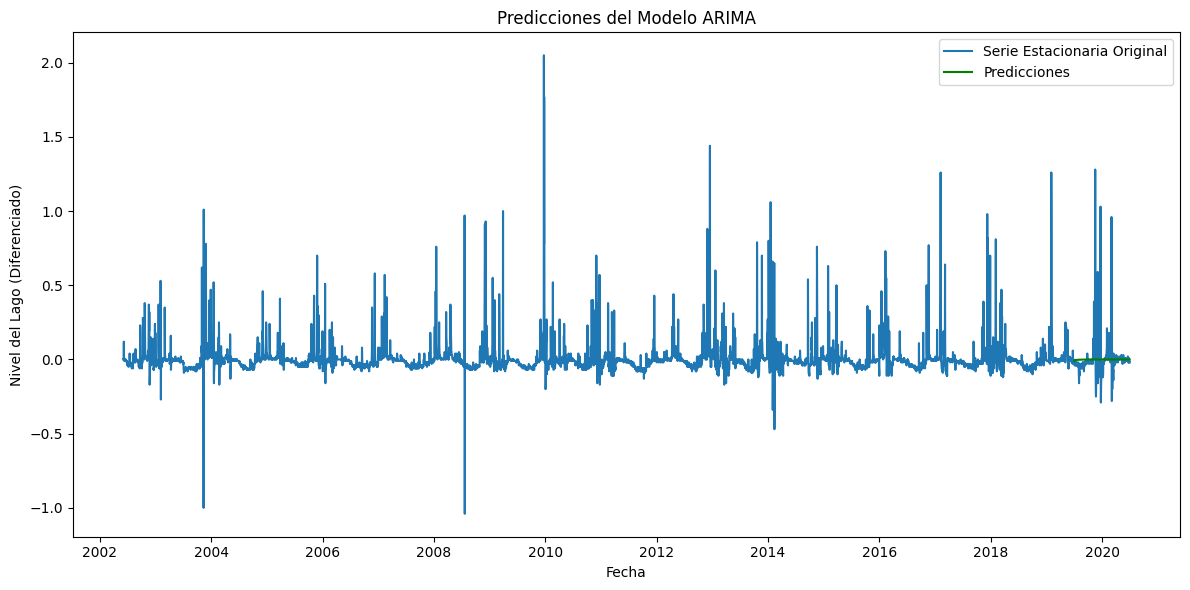

In [13]:
print("\n--- Predicción ---")

# Realizar predicciones
n_predictions = 365
forecast = model.predict(n_predictions)

# Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(lake_level_stationary, label='Serie Estacionaria Original')
plt.plot(lake_level_stationary.index[-n_predictions:], forecast, color='green', label='Predicciones')
plt.title('Predicciones del Modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Nivel del Lago (Diferenciado)')
plt.legend()
plt.tight_layout()
plt.show()

## Guardar el Modelo

In [32]:
model_path = "../models/Model_auto_arima.pkl"
with open(model_path, "wb") as file:
    pickle.dump(model, file)
print(f"\nModelo ARIMA guardado en: {model_path}")


Modelo ARIMA guardado en: ../models/Model_auto_arima.pkl
